In [156]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# 第10章
---
# 时间序列

不管在哪个领域中，时间序列（time series）数据都是一种重要的结构化数据形式。在多个时间点观察或测量到的任何事物都可以形成一段时间序列。时间序列有固定频率的，也可以是不定期的。数据的意义取决于具体的应用场景，主要有以下几种：

- 时间戳（timestamp），特定的时刻
- 固定时期（period），如2007年1月或2010年全年
- 时间间隔（interval），由起始和结束时间戳表示。时期（period）可以被看做间隔（interval）的特例
- 实验或过程时间，每个时间点都是相对于特定起始时间的一个度量。例如，从放入烤箱时起，每秒钟饼干的直径。

本章主要讲解前三种时间序列，timestamp、period、interval。许多技术都可以用于处理实验型时间序列，其索引可能是一个整数或浮点数（表示从实验开始算起已经过去的时间）。最简单也最常见的时间序列都是用时间戳进行索引的。

pandas提供的时间序列处理工具和数据算法：轻松的切片/切块、聚合、对定期/不定期的时间序列进行重采样等。对金融和经济数据尤为游泳，当然也可以分析任何带时间序列的数据集，如服务器日志数据。

## 日期和时间数据类型及工具

Python标准库包含用于日期（date）和时间（time）数据的数据类型，且有日历方面的功能。主要用到**datetime、time、以及calendar模块**。datetime.datetime是用的最多的数据类型：

In [157]:
from datetime import datetime

now = datetime.now()
now

datetime.datetime(2016, 7, 14, 15, 16, 56, 873000)

In [158]:
now.year, now.month, now.day

(2016, 7, 14)

datetime以毫秒形式存储日期和时间。datetime.timedelta表示两个datetime对象之间的时间差：

In [159]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(926, 56700)

In [160]:
delta.days

926

In [161]:
delta.seconds

56700

可以给datetime对象加上（或减去）一个或多个timedelta，这样会产生一个新对象：

In [162]:
from datetime import timedelta

start = datetime(2016, 1, 7)
start + timedelta(10)

datetime.datetime(2016, 1, 17, 0, 0)

In [163]:
start - 2 * timedelta(11, 11)

datetime.datetime(2015, 12, 15, 23, 59, 38)

Python datetime的数据类型

类型 | 说明
- | -
date | 以公历形式存储日历日期（年、月、日）
time | 将时间存储为时、分、秒、毫秒
datetime | 存储日期和时间
timedelta | 表示两个datetime值之间的差（日、秒、毫秒）

### 字符串和datetime的相互转换
利用str或strftime方法（传入一个格式化字符串），datetime对象和pandas的Timestamp对象可以被格式化为字符串：

In [164]:
stamp = datetime(2011, 1, 3)

str(stamp)

'2011-01-03 00:00:00'

In [165]:
stamp.strftime('%Y-%m-%d')

'2011-01-03'

In [166]:
value = '2016-07-05'

datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2016, 7, 5, 0, 0)

In [167]:
datestrs = ['7/11/2016', '7/15/2016']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2016, 7, 11, 0, 0), datetime.datetime(2016, 7, 15, 0, 0)]

datetime.strptime是通过已知格式进行日期解析的最佳方式。但是每次都要编写格式定义是很麻烦的事情，尤其一些常见的格式。这样可以用deteutil这个三方包中的parser.parse方法：

In [168]:
from dateutil.parser import parse

parse('2011/07/19')

datetime.datetime(2011, 7, 19, 0, 0)

In [169]:
# dateutil可以寄解析几乎所有人能够理解的日期形式：（中文好像不行）
parse('Jan 31, 1997 10:22 PM')

datetime.datetime(1997, 1, 31, 22, 22)

In [170]:
# 国际通用格式中，经常有日在前的，传入dayfirst=True即可：
parse('6/12/2016', dayfirst=True)

datetime.datetime(2016, 12, 6, 0, 0)

pandas通常是用于处理成组日期的，不管是DataFrame的轴索引还是列。to_datetime的方法可以解析多种不同的日期表示形式。对标准日期如ISO8601的解析非常快。

In [171]:
datestrs

['7/11/2016', '7/15/2016']

In [172]:
import pandas as pd
pd.to_datetime(datestrs)

DatetimeIndex(['2016-07-11', '2016-07-15'], dtype='datetime64[ns]', freq=None)

In [173]:
# 处理缺失值（None、空字符串等）:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2016-07-11', '2016-07-15', 'NaT'], dtype='datetime64[ns]', freq=None)

In [174]:
idx[2] # not a time pandas中时间戳数据的NA值

NaT

In [175]:
pd.isnull(idx)

array([False, False,  True], dtype=bool)

**警告：**dateutil.parser会把一些不是日期的字符串认作是日期（比如“42”会被解析为2042年的今天）。

datetime格式定义（兼容ISO C89）

代码 | 说明
- | -
%Y | 4位数的年
%y | 2位数的年
%m | 2位数的月[01,12]
%d | 2位数的日[01,31]
%H | 时（24小时制）[00,23]
%I | 时（12小时制）[01,12]
%M | 2位数的分[00,59]
%S | 秒[00,61]（秒60和秒61用于闰秒）
%w | 用整数表示的星期几[0(星期天)，6]
%U | 每年的第几周[00,53]。星期天被任务是每周的第一天，每年第一个星期天之前的那几天被任务是“第0周”
%W | 每年的第几周[00,53]。星期一被任务是每周的第一天，每年第一个星期一之前的那几天被任务是“第0周”
%z | 以+HHMM或-HHMM表示的UTC时区偏移量，如果时间对象为naive，则返回空字符串
%F | %Y-%m-%d简写形式，例如2016-07-11
%D | %m/%d/%y简写形式，例如11/07/12

datetime对象还有一些特定于当前环境（位于不同国家或使用不同语言的系统）的格式化选项。例如，德语或法语系统所用的鱼粉简写就与英语系统所用的不同。

特定于当前环境的日期格式

代码 | 说明
- | -
%a | 星期几的简写
%A | 星期几的全称
%b | 月份的简写
%B | 月份的全称
%c | 完整的日期和时间，例如“Tue 01 May 2012 04:20:57 PM”
%p | 不同环境中的AM或PM
%x | 适合于当前环境的日期格式，例如，在美国，“May 1,2012”会产生“05/01/2012”
%X | 适合于当前环境的时间格式，例如“04:24:12 PM”

## 时间序列基础
pandas最基本的时间序列类型就是以时间戳（通常以Python字符串或datetime对象表示）为索引的Series：

In [176]:
from datetime import datetime
from pandas import Series, DataFrame
import numpy as np

dates = [datetime(2016, 7, 12), datetime(2016,7, 15), datetime(2016,7, 18),
         datetime(2016,7, 19), datetime(2016,7, 20), datetime(2016,7, 22)]
ts = Series(np.random.randn(6), index=dates)

ts

2016-07-12    0.336017
2016-07-15   -0.804391
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
2016-07-22   -0.784171
dtype: float64

这些datetime对象实际上是被放在一个DatetimeIndex中的。现在，变量ts成为了一个TimeSeries了：

In [177]:
type(ts)

pandas.core.series.Series

In [178]:
ts.index

DatetimeIndex(['2016-07-12', '2016-07-15', '2016-07-18', '2016-07-19',
               '2016-07-20', '2016-07-22'],
              dtype='datetime64[ns]', freq=None)

In [179]:
# 跟其他Series一样，不同索引的时间序列之间的算数运算会自动按日期对齐：
ts + ts[::2]

2016-07-12    0.672033
2016-07-15         NaN
2016-07-18   -0.727403
2016-07-19         NaN
2016-07-20   -0.297232
2016-07-22         NaN
dtype: float64

In [180]:
# pandas用Numpy的datetime64数据类型以纳秒形式存储时间戳：
ts.index.dtype

dtype('<M8[ns]')

In [181]:
# DatetimeIndex中的各个标量值是pandas的Timestamp对象：
stamp = ts.index[0]

In [182]:
stamp

Timestamp('2016-07-12 00:00:00')

只要有需要，Timestamp可以随时自动转换为datetime对象。此外，它还可以储存频率信息，且知道如何执行时区转换以及其他操作。

### 索引、选取、子集构造
由于TimeSeries是Series的一个子类，所以在索引以及数据选取方面它们的行为是一样的：

In [183]:
stamp = ts.index[2]
ts[stamp]

-0.36370167719454133

In [184]:
# 传入一个可以被解释为日期的字符串：
ts['7/18/2016']

-0.36370167719454133

In [185]:
ts['20160718']

-0.36370167719454133

In [186]:
# 对于较长的时间序列，只需传入年或年月即可轻松选取数据的切片：
longer_ts = Series(np.random.randn(1000), index=pd.date_range('1/1/2016', periods=1000))
longer_ts

2016-01-01   -1.103033
2016-01-02    1.477602
2016-01-03   -1.452240
2016-01-04   -0.138724
2016-01-05   -1.646094
2016-01-06    0.056149
2016-01-07    0.215661
2016-01-08    0.288295
2016-01-09    0.099055
2016-01-10   -0.191248
2016-01-11    0.073184
2016-01-12    0.723378
2016-01-13   -0.493405
2016-01-14    0.100046
2016-01-15    0.807459
2016-01-16   -0.317166
2016-01-17   -0.455695
2016-01-18   -0.054773
2016-01-19    0.847093
2016-01-20    0.097136
2016-01-21    0.543153
2016-01-22   -1.922554
2016-01-23    0.276064
2016-01-24    0.277287
2016-01-25   -0.318388
2016-01-26   -0.170401
2016-01-27   -1.219811
2016-01-28    1.294946
2016-01-29   -0.646749
2016-01-30   -0.896232
                ...   
2018-08-28    0.288795
2018-08-29   -0.935848
2018-08-30    0.789008
2018-08-31   -0.377760
2018-09-01   -1.351935
2018-09-02    0.162873
2018-09-03   -0.058219
2018-09-04   -0.590409
2018-09-05   -1.561563
2018-09-06   -0.808662
2018-09-07    0.425402
2018-09-08   -1.192673
2018-09-09 

In [187]:
longer_ts['2017']

2017-01-01   -0.628029
2017-01-02    0.640656
2017-01-03   -1.721025
2017-01-04   -0.114864
2017-01-05   -0.452288
2017-01-06   -0.714008
2017-01-07   -0.435839
2017-01-08    0.522355
2017-01-09    0.287134
2017-01-10   -0.789492
2017-01-11    1.215676
2017-01-12    2.614154
2017-01-13   -0.956412
2017-01-14    0.337161
2017-01-15    0.326156
2017-01-16   -1.041365
2017-01-17   -0.594335
2017-01-18   -1.632378
2017-01-19    0.186503
2017-01-20   -0.285549
2017-01-21   -0.544661
2017-01-22    0.126042
2017-01-23   -0.679283
2017-01-24    0.349382
2017-01-25    0.520495
2017-01-26    0.380421
2017-01-27   -0.470495
2017-01-28   -0.176687
2017-01-29    0.077378
2017-01-30   -0.363898
                ...   
2017-12-02   -1.481341
2017-12-03    1.984936
2017-12-04    0.409854
2017-12-05   -0.557249
2017-12-06   -0.666404
2017-12-07   -0.212746
2017-12-08    0.937685
2017-12-09   -0.387364
2017-12-10   -0.307493
2017-12-11    0.535937
2017-12-12   -1.436745
2017-12-13   -1.425622
2017-12-14 

In [188]:
longer_ts['2018-03']

2018-03-01   -0.821542
2018-03-02    0.111879
2018-03-03    0.399524
2018-03-04    1.247078
2018-03-05    0.278866
2018-03-06   -0.587874
2018-03-07   -0.015381
2018-03-08   -0.014274
2018-03-09    0.777707
2018-03-10   -1.322012
2018-03-11    0.225206
2018-03-12    0.525335
2018-03-13    1.215021
2018-03-14   -1.254807
2018-03-15   -1.014751
2018-03-16   -0.646867
2018-03-17   -0.572734
2018-03-18   -0.472090
2018-03-19    0.015786
2018-03-20   -1.447384
2018-03-21    0.147699
2018-03-22   -0.674408
2018-03-23    1.587673
2018-03-24    0.115015
2018-03-25    1.460738
2018-03-26    0.120551
2018-03-27    1.797401
2018-03-28   -0.190769
2018-03-29    0.652817
2018-03-30    0.667554
2018-03-31   -0.305042
Freq: D, dtype: float64

In [189]:
# 通过日期进行切片的方式只对规则Series有效：
ts[datetime(2016, 7, 15):]

2016-07-15   -0.804391
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
2016-07-22   -0.784171
dtype: float64

In [190]:
# 大部分时间序列数据都是按照时间先后排序的，可以用不存在与该时间序列中的时间戳对其进行切片（范围查询）：
ts

2016-07-12    0.336017
2016-07-15   -0.804391
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
2016-07-22   -0.784171
dtype: float64

In [191]:
ts['7/13/2016':'7/21/2016']

2016-07-15   -0.804391
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
dtype: float64

根之前一样，这里可以传入字符串日期、datetime或Timestamp。注意，这样切片所产生的是源时间序列的视图，根NumPy数组的切片运算是一样的。此外，还有一个等价的实例方法也可以截取两个日期之间TimeSeries：

In [192]:
ts.truncate(after='7/16/2016')

2016-07-12    0.336017
2016-07-15   -0.804391
dtype: float64

In [193]:
# 上面这些操作对DataFrame也有效。例如，对DataFrame的行进行索引：
dates = pd.date_range('1/1/2016', periods=100, freq='W-WED')
long_df = DataFrame(np.random.randn(100, 4),
                   index=dates,
                   columns=['Colorado', 'Texas', 'New York', 'Ohio'])

long_df.ix['5-2016']

,Colorado,Texas,New York,Ohio
2016-05-04,-0.424735,-0.717260,0.262041,-0.615922
2016-05-11,-1.015587,0.332036,0.107611,-0.289552
2016-05-18,0.422269,0.491712,0.475879,0.288083
2016-05-25,-1.388990,1.595024,1.245831,-0.358692


### 带有重复索引的时间序列
在某些场景中国，可能会存在多个观测数据落在同一个时间点上的情况。下面就是一个例子：

In [194]:
dates = pd.DatetimeIndex(['1/1/2016', '1/2/2016', '1/2/2016', '1/2/2016', '1/3/2016'])
dup_ts = Series(np.arange(5), index=dates)

dup_ts

2016-01-01    0
2016-01-02    1
2016-01-02    2
2016-01-02    3
2016-01-03    4
dtype: int32

In [195]:
# 通过检查索引的is_unique属性，我们就可以知道它是不是唯一的：
dup_ts.index.is_unique

False

In [196]:
# 索引时可能会产生标量值或切片，具体看时间点是否重复：
dup_ts['2016/01/01']

0

In [197]:
dup_ts['2016/01/02']

2016-01-02    1
2016-01-02    2
2016-01-02    3
dtype: int32

In [198]:
# 聚合非唯一时间戳，可以使用groupby并传入level=0（索引的唯一一层！）：
grouped = dup_ts.groupby(level=0)
grouped.mean()

2016-01-01    0
2016-01-02    2
2016-01-03    4
dtype: int32

In [199]:
grouped.count()

2016-01-01    1
2016-01-02    3
2016-01-03    1
dtype: int64

##  日期的范围、频率以及移动
pandas中的时间序列一般被任务是不规则的，它没有固定的频率，对大部分应用而言，这是无所谓的，但是它常常需要以。某种相对规定的频率进行分析，比如每日、每月、每15分钟等（这样自然会在时间序列中引入缺失值）。还好，*pandas有套标准时间序列频率以及用于重采样、频率推断、生成固定频率日期范围的工具*。例如，将之前时间序列转换为一个具有固定频率（每日）的时间序列，只需要调用resample即可：

In [200]:
ts

2016-07-12    0.336017
2016-07-15   -0.804391
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
2016-07-22   -0.784171
dtype: float64

In [201]:
ts.resample('D').mean()

2016-07-12    0.336017
2016-07-13         NaN
2016-07-14         NaN
2016-07-15   -0.804391
2016-07-16         NaN
2016-07-17         NaN
2016-07-18   -0.363702
2016-07-19   -0.683905
2016-07-20   -0.148616
2016-07-21         NaN
2016-07-22   -0.784171
Freq: D, dtype: float64

频率的转换（或重采样）是一个比较大的主题，稍后将专门用一节讨论。

### 生成日期范围
pandas.date_range可用于生成指定长度的DatetimeIndex：

In [202]:
index = pd.date_range('4/1/2016', '6/1/2016')
index

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22',
               '2016-05-23', '2016-05-24', '2016-05-25', '2016-05-26',
      

*默认情况下，date_range会产生按天计算的时间点*，如果只传入起始或结束日期，那就还得传入一个表示一段时间的数字：

In [203]:
pd.date_range(start='4/1/2016', periods=20)

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20'],
              dtype='datetime64[ns]', freq='D')

In [204]:
pd.date_range(end='6/1/2016', periods=20)

DatetimeIndex(['2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22', '2016-05-23', '2016-05-24',
               '2016-05-25', '2016-05-26', '2016-05-27', '2016-05-28',
               '2016-05-29', '2016-05-30', '2016-05-31', '2016-06-01'],
              dtype='datetime64[ns]', freq='D')

起始和结束日期定义了日期索引的严格边界。例如，如果你想要生成一个由每月最后一个工作日组成的日期索引、可以传入‘BM’频率（business end of month），这样就只会包含时间间隔内（或刚好在边界上的）符合频率要求的日期：

In [205]:
pd.date_range('1/1/2000','12/31/2000', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30', '2000-12-29'],
              dtype='datetime64[ns]', freq='BM')

In [206]:
# date_range默认会保留起始和结束时间戳的时间信息：
pd.date_range('7/12/2016 12:01:40', periods=5)

DatetimeIndex(['2016-07-12 12:01:40', '2016-07-13 12:01:40',
               '2016-07-14 12:01:40', '2016-07-15 12:01:40',
               '2016-07-16 12:01:40'],
              dtype='datetime64[ns]', freq='D')

In [207]:
# 产生一组被规范化（normalize）到午夜的时间戳。normalize选项即可实现该功能：
pd.date_range('7/12/2016 12:51:42', periods=5, normalize=True)

DatetimeIndex(['2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15',
               '2016-07-16'],
              dtype='datetime64[ns]', freq='D')

### 频率和日期偏移量
pandas中的频率是由一个基础频率（base frequency）和一个乘数组成的。基础频率通常以一个字符串别名表示，比如“M”表示每月，“H”表示每小时。

对于每个基础平率，都有一个被称为**日期偏移量（date offset）**的对象与之对应，例如，按小时计算的频率可以用**Hour类**表示：

In [208]:
from pandas.tseries.offsets import Hour, Minute

hour = Hour()
hour

<Hour>

In [209]:
# 传入一个整数即可定义偏移量的倍数
four_hours = Hour(4)
four_hours

<4 * Hours>

一般，无需显式创建这样的对象，只需使用诸如“H”或“4H”这样的字符串别名即可。在基础频率前面放上一个整数即可创建倍数：

In [210]:
pd.date_range('1/1/2016', '1/3/2016 23:59', freq='4H')

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 04:00:00',
               '2016-01-01 08:00:00', '2016-01-01 12:00:00',
               '2016-01-01 16:00:00', '2016-01-01 20:00:00',
               '2016-01-02 00:00:00', '2016-01-02 04:00:00',
               '2016-01-02 08:00:00', '2016-01-02 12:00:00',
               '2016-01-02 16:00:00', '2016-01-02 20:00:00',
               '2016-01-03 00:00:00', '2016-01-03 04:00:00',
               '2016-01-03 08:00:00', '2016-01-03 12:00:00',
               '2016-01-03 16:00:00', '2016-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [211]:
pd.date_range('1/1/2016', '1/3/2016', freq='4H')

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 04:00:00',
               '2016-01-01 08:00:00', '2016-01-01 12:00:00',
               '2016-01-01 16:00:00', '2016-01-01 20:00:00',
               '2016-01-02 00:00:00', '2016-01-02 04:00:00',
               '2016-01-02 08:00:00', '2016-01-02 12:00:00',
               '2016-01-02 16:00:00', '2016-01-02 20:00:00',
               '2016-01-03 00:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [212]:
# 大部分偏移量对象都可通过加法链接：
Hour(2) + Minute(28)

<148 * Minutes>

In [213]:
# 2h30min可以高效地解析为等效的表达式：
pd.date_range('1/1/2016', periods=10, freq='1h29min11s')

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:29:11',
               '2016-01-01 02:58:22', '2016-01-01 04:27:33',
               '2016-01-01 05:56:44', '2016-01-01 07:25:55',
               '2016-01-01 08:55:06', '2016-01-01 10:24:17',
               '2016-01-01 11:53:28', '2016-01-01 13:22:39'],
              dtype='datetime64[ns]', freq='5351S')

有些频率的时间点间隔不均匀，如M（日历月末）和BM（每月最后一个工作日）就取决于每月的天数，对于后者，还要考虑月末是不是周末。将这些成为锚点偏移量（anchored offset）。

pandas中的频率代码和日期偏移量类

别名 | 偏移量类型 | 说明
- | - | -
D | Day | 每日历日
B | BusinessDay | 每工作日
H | Hour | 每小时
T或min | Mniute | 每分
S | Second | 每秒
L或ms | Milli | 每毫秒（即每千分之一秒）
U | Micro | 每微妙（百万分之一秒）
M | MonthEnd | 每月最后一个日历日
BM | BusinessMonthEnd | 每月最后一个工作日
MS | MonthBegin | 每月第一个日历日
BMS | BusinessMonthBegin | 每月第一个工作日

> **详见onenote**

### WOM日期
week of month 非常实用的频率类，它以WOM开头。例如“每月第三个星期五”之类的日期：

In [214]:
rng = pd.date_range('1/1/2016', '9/1/2016', freq='WOM-3FRI')

In [215]:
list(rng)

[Timestamp('2016-01-15 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-02-19 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-03-18 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-04-15 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-05-20 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-06-17 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-07-15 00:00:00', offset='WOM-3FRI'),
 Timestamp('2016-08-19 00:00:00', offset='WOM-3FRI')]

### 移动（超前和之后）数据
移动（shifting）指的是沿着时间轴将数据前移或后移。Series、DF都有一个shift方法用于执行单纯的前移或后移操作，保持索引不变：

In [216]:
ts = Series(np.random.randn(4),
           index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31    0.565872
2000-02-29   -0.237786
2000-03-31   -0.244187
2000-04-30   -0.449057
Freq: M, dtype: float64

In [217]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31    0.565872
2000-04-30   -0.237786
Freq: M, dtype: float64

In [218]:
ts.shift(-2)

2000-01-31   -0.244187
2000-02-29   -0.449057
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

shift通常用于计算一个时间序列或多个时间序列中的*百分比变化*：
```
ts / ts.shift(1) -1
```

单纯的位移操作不会修改索引，所以**部分数据会被丢弃**。因此，如果频率已知，则可以传递给shift以实现时间戳位移而不是对数据简单的位移，这样可以避免数据丢失

In [219]:
ts.shift(2, freq='M')

2000-03-31    0.565872
2000-04-30   -0.237786
2000-05-31   -0.244187
2000-06-30   -0.449057
Freq: M, dtype: float64

In [220]:
ts.shift(3, freq='D')

2000-02-03    0.565872
2000-03-03   -0.237786
2000-04-03   -0.244187
2000-05-03   -0.449057
dtype: float64

In [221]:
ts.shift(1, freq='3D')

2000-02-03    0.565872
2000-03-03   -0.237786
2000-04-03   -0.244187
2000-05-03   -0.449057
dtype: float64

In [222]:
ts.shift(1, freq='15T')

2000-01-31 00:15:00    0.565872
2000-02-29 00:15:00   -0.237786
2000-03-31 00:15:00   -0.244187
2000-04-30 00:15:00   -0.449057
Freq: M, dtype: float64

### 通过偏移量对日期进行位移
pandas的日期偏移量还可以用在datetime或Timestamp对象上：

In [223]:
from pandas.tseries.offsets import Day, MonthEnd

now = datetime(2016, 7, 17)
now + 3 * Day()

Timestamp('2016-07-20 00:00:00')

In [224]:
# 如果加锚点偏移量，第一次增量会将原日期向前滚动到符合频率的下一个日期：
now + MonthEnd()

Timestamp('2016-07-31 00:00:00')

In [225]:
now + MonthEnd(2)

Timestamp('2016-08-31 00:00:00')

In [226]:
# 通过锚点偏移量的rollforward和rollback的方法，可显式地将日期向前或向后滚动：
offset = MonthEnd()

offset.rollforward(now)

Timestamp('2016-07-31 00:00:00')

In [227]:
offset.rollback(now)

Timestamp('2016-06-30 00:00:00')

In [228]:
# 结合groupby使用这两个滚动方法：
ts = Series(np.random.randn(20),
           index=pd.date_range('1/15/2016', periods=20, freq='4d'))
ts

2016-01-15    0.633015
2016-01-19   -0.748027
2016-01-23    1.700974
2016-01-27   -0.847926
2016-01-31   -0.528870
2016-02-04   -1.226967
2016-02-08    0.615057
2016-02-12    2.067587
2016-02-16    0.278605
2016-02-20    0.098274
2016-02-24   -0.477143
2016-02-28   -0.873986
2016-03-03    0.115079
2016-03-07    0.908438
2016-03-11   -0.337327
2016-03-15    0.343221
2016-03-19    0.074302
2016-03-23    1.536076
2016-03-27    0.712246
2016-03-31    1.328955
Freq: 4D, dtype: float64

In [229]:
ts.groupby(offset.rollforward).sum()

2016-01-31    0.209165
2016-02-29    0.481427
2016-03-31    4.680991
dtype: float64

In [230]:
# resample可以更快速的实现上述的功能
ts.resample('M').sum()

2016-01-31    0.209165
2016-02-29    0.481427
2016-03-31    4.680991
Freq: M, dtype: float64

## 时区处理
夏令时（DST）转变，许多人选择以协调世界时间来处理时间序列。时区是以UTC偏移量的形式来表示的，例如，夏令时期间，纽约比UTC慢4小时，而在全年其他时间则比UTC慢5小时。

在Python中，时区信息来自[第三方库pytz](http://pytz.sourceforge.net/)，使Python可以使用Olson数据库。pandas包含了pytz的功能，只要记得时区的名称即可，时区名可以在文档中找到，也可以交互的方式查看：

In [231]:
import pytz

pytz.common_timezones[:]

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Tripoli',
 'Africa/Tunis',
 'Africa/Wi

In [232]:
# 获取时区对象：
tz = pytz.timezone('US/Eastern')

In [233]:
tz

<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>

### 本地化和转换
默认情况下，pandas中的时间序列是单纯的（naive）时区。

In [234]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = Series(np.random.randn(len(rng)), index=rng)

In [235]:
print(ts.index.tz)

None


In [236]:
# 生成时加上时区集
pd.date_range('3/9/2012 9:30', periods=6, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [237]:
# 单纯到本地化的转换是通过tz_localize方法处理的：
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -0.226425
2012-03-10 09:30:00+00:00   -1.128373
2012-03-11 09:30:00+00:00   -0.365051
2012-03-12 09:30:00+00:00   -0.905371
2012-03-13 09:30:00+00:00    1.480595
2012-03-14 09:30:00+00:00   -0.270082
Freq: D, dtype: float64

In [238]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [239]:
# 被本地化到特定时区后，可以用tz_convert转换到别的时区：
ts_utc.tz_convert('Asia/Shanghai')

2012-03-09 17:30:00+08:00   -0.226425
2012-03-10 17:30:00+08:00   -1.128373
2012-03-11 17:30:00+08:00   -0.365051
2012-03-12 17:30:00+08:00   -0.905371
2012-03-13 17:30:00+08:00    1.480595
2012-03-14 17:30:00+08:00   -0.270082
Freq: D, dtype: float64

In [240]:
# tz_localize和tz_convert也是DatetimeIndex的实例方法：
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

### 操作时区意识型Timestamp对象
跟时间序列和日期范围差不多，Timestamp对象也能被从单纯型（naive）本地化为时区意识型（time zone-aware），并从一个时区转换到另一个时区：

In [241]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')
stamp_utc.tz_convert('US/Eastern')

Timestamp('2011-03-11 23:00:00-0500', tz='US/Eastern')

In [242]:
# 创建Timestamp时，可以传入时区信息：
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

时区意识型Timestamp对象在内部保存了一个UTC时间戳值（自UNIX纪元1970年1月1日算起的纳秒数）。这个UTC值在时区转换过程中是不会发生变化的：

In [243]:
stamp_utc.value

1299902400000000000L

In [244]:
stamp_utc.tz_convert('US/Eastern').value

1299902400000000000L

In [245]:
# 使用pandas的DateOffset对象执行时间算术运算时，运算过程会自动关注是否存在夏令时转变期：

#夏令时转变前30分钟
from pandas.tseries.offsets import Hour

stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [246]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

In [247]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [248]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

### 不同时区之间的运算

## 时期及其算术运算

时期，Period类表示的就是这种数据类型，其构造函数需要用到一个字符串或整数，以及频率：

In [249]:
p = pd.Period(2016, freq='A-DEC')
p

Period('2016', 'A-DEC')

In [250]:
# 位移效果
p + 5

Period('2021', 'A-DEC')

In [251]:
p - 2

Period('2014', 'A-DEC')

In [252]:
# Period对象有相同频率，它们的差就是它们之间的单位数量：
pd.Period('2019', freq='A-DEC') - p

3L

In [253]:
# period_range创建时期范围
rng = pd.period_range('1/1/2000', '6/30/2000', freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='int64', freq='M')

In [254]:
# 用作索引
Series(np.random.randn(6), index=rng)

2000-01   -0.959087
2000-02    0.194027
2000-03    0.202225
2000-04    0.092817
2000-05    1.293154
2000-06    0.113919
Freq: M, dtype: float64

In [255]:
# PeriodIndex类的构造函数允许直接使用一组字符串：
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='int64', freq='Q-DEC')

### 时期频率转换
Period和PeriodIndex对象都可以通过其asfreq方法转换为别的频率。

In [256]:
p = pd.Period('2007', freq='A-DEC')

p.asfreq('M', how='start')

Period('2007-01', 'M')

In [257]:
p.asfreq('M', how='end')

Period('2007-12', 'M')

In [258]:
p = pd.Period('2007', freq='A-JUN') # 以六月底为财政年的算法，开始于06年的7月

p.asfreq('M', how='start')

Period('2006-07', 'M')

In [259]:
p.asfreq('M', how='end')

Period('2007-06', 'M')

In [260]:
# A-JUN频率下的2007-8实际上是属于周期2008年的
p = pd.Period('2007-8', 'M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

### 按季度计算的时期频率
季度型数据在会计金融领域很常见，许多都会涉及“财政年”的概念，不同的企业会有不同的定义，pandas支持12种有可能的季度型频率，Q-JAN到Q-DEC：

In [261]:
p = pd.Period('2012Q4', freq='Q-SEP') # 2012年的10月开始为下一个财政年2013Q1
p

Period('2012Q4', 'Q-SEP')

In [262]:
p.asfreq('D','start')

Period('2012-07-01', 'D')

In [263]:
p.asfreq('D', 'end')

Period('2012-09-30', 'D')

In [264]:
# 获取该季度倒数第二个工作日下午4点的时间戳：
p4pm = (p.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
p4pm

Period('2012-09-27 16:00', 'T')

In [265]:
p4pm.to_timestamp()

Timestamp('2012-09-27 16:00:00')

In [266]:
# period_range用于生成季度范围
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [267]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

### 将Timestamp转换为Period（及其反向过程）
to_period方法，将时间戳索引的Series和DF对象转换为以时期为索引：

In [268]:
rng = pd.date_range('1/1/2000', periods=3, freq='M')
ts = Series(np.random.randn(3), index=rng)
pts = ts.to_period()

In [269]:
ts

2000-01-31    1.290346
2000-02-29    1.229090
2000-03-31    0.796840
Freq: M, dtype: float64

In [270]:
pts

2000-01    1.290346
2000-02    1.229090
2000-03    0.796840
Freq: M, dtype: float64

In [271]:
# 新的PeriodIndex的频率是从时间戳对推断过来，允许存在重复时期：
rng = pd.date_range('1/29/2016', periods=6, freq='D')
ts2 = Series(np.random.randn(6), index=rng)
ts2.to_period('M')

2016-01   -1.395777
2016-01    1.458689
2016-01   -1.480922
2016-02    1.363053
2016-02   -0.327505
2016-02    0.214272
Freq: M, dtype: float64

In [272]:
# to_timestamp转换为是时间戳：
pts.to_timestamp(how='end')

2000-01-31    1.290346
2000-02-29    1.229090
2000-03-31    0.796840
Freq: M, dtype: float64

### 通过数组创建PeriodIndex
固定频率的数据集会将时间信息分开存放在多个列中，如下面这个宏观经济数据集中，年度和季度就分别存放在不同的列中：

In [273]:
data = pd.read_csv('old-file/ch08/macrodata.csv')
data[:10]

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81


In [274]:
data.year.head()

0    1959.0
1    1959.0
2    1959.0
3    1959.0
4    1960.0
Name: year, dtype: float64

In [275]:
data.quarter.head()

0    1.0
1    2.0
2    3.0
3    4.0
4    1.0
Name: quarter, dtype: float64

In [276]:
# 两个数组以及一个频率传入PeriodIndex，就可以合并成为DataFrame的一个索引：
index = pd.PeriodIndex(year=data.year, quarter=data.quarter, freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='int64', length=203, freq='Q-DEC')

In [277]:
data.index = index
data[:10]

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19
1960Q2,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55
1960Q3,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34
1960Q4,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08
1961Q1,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77
1961Q2,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81


In [278]:
data.infl

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
1960Q2    0.14
1960Q3    2.70
1960Q4    1.21
1961Q1   -0.40
1961Q2    1.47
1961Q3    0.80
1961Q4    0.80
1962Q1    2.26
1962Q2    0.13
1962Q3    2.11
1962Q4    0.79
1963Q1    0.53
1963Q2    2.75
1963Q3    0.78
1963Q4    2.46
1964Q1    0.13
1964Q2    0.90
1964Q3    1.29
1964Q4    2.05
1965Q1    1.28
1965Q2    2.54
1965Q3    0.89
1965Q4    2.90
1966Q1    4.99
1966Q2    2.10
          ... 
2002Q2    1.56
2002Q3    2.66
2002Q4    3.08
2003Q1    1.31
2003Q2    1.09
2003Q3    2.60
2003Q4    3.02
2004Q1    2.35
2004Q2    3.61
2004Q3    3.58
2004Q4    2.09
2005Q1    4.15
2005Q2    1.85
2005Q3    9.14
2005Q4    0.40
2006Q1    2.60
2006Q2    3.97
2006Q3   -1.58
2006Q4    3.30
2007Q1    4.58
2007Q2    2.75
2007Q3    3.45
2007Q4    6.38
2008Q1    2.82
2008Q2    8.53
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, dtype: float64

## 重采样及频率转换
***resampling***指的是将时间序列从一个频率转换到另外一个频率的处理过程。高频率数据聚合到低频率称为*降采样（downsampling）*，低频率数据转换到高频率称为*升采样（upsampling）*。

pandas对象都带有一个resample方法，各种频率转换工作的主力函数：

In [279]:
rng = pd.date_range('1/1/2000', periods=100, freq='D')
ts = Series(np.random.randn(len(rng)), index=rng)
ts.resample('M').mean()

2000-01-31   -0.037841
2000-02-29    0.160175
2000-03-31    0.018833
2000-04-30    0.244742
Freq: M, dtype: float64

In [280]:
ts.resample('M', kind='period').mean()

2000-01   -0.037841
2000-02    0.160175
2000-03    0.018833
2000-04    0.244742
Freq: M, dtype: float64

**resample**是一个灵活高效的方法，可用于处理非常大的时间序列。

resample方法的参数
> 详见onenote

### 降采样
在用resample对数据进行降采样时，需要考虑两样东西：
- 各区间哪边是闭合的
- 如何标记各个聚合面元，用区间的开头还是末尾

首先，老看一些‘一分钟’数据：

In [281]:
rng = pd.date_range('1/1/2000', periods=12, freq='T')
ts = Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

In [282]:
# 求和的方式，聚合到“五分钟”
ts.resample('5min').sum() # 默认左边闭合，以时间戳的左边为标记

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int32

In [283]:
ts.resample('5min', closed='right', label='right').sum() # 右闭合，则第一个在上一组中

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

### OHLC重采样
金融领域的时间序列聚合方式，各面元的四个值：
1. 第一个值，open，开盘
2. high，最大值
3. low，最小值
4. close，收盘

传入how='ohlc'即得到四种聚合值得DF。高效，只需一次扫描即可计算出结果：

In [284]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


### 通过groupby进行重采样
另一种降采样的办法是pandas的groupby功能。

例如，打算根据月份或星期几进行分组，只需传入一个能够访问时间序列的索引上的这些字段的函数即可：

In [285]:
rng = pd.date_range('1/1/2000', periods=100, freq='D')
ts = Series(np.arange(100), index=rng)
ts.groupby(lambda x: x.month).mean()

1    15
2    45
3    75
4    95
dtype: int32

In [286]:
ts.groupby(lambda x: x.weekday).mean()

0    47.5
1    48.5
2    49.5
3    50.5
4    51.5
5    49.0
6    50.0
dtype: float64

### 升采样和插值
从低频转换到高频，就不需要聚合了。

In [287]:
frame =  DataFrame(np.random.randn(2, 4),
                  index=pd.date_range('1/1/2000', periods=2, freq='W-WED'),
                  columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01-05,-0.431813,0.345187,0.281977,-0.050310
2000-01-12,0.447424,0.593226,0.634475,-0.898403


In [288]:
# 重采样到日频率，默认会引入缺失值
df_daily = frame.resample('D')
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.431813,0.345187,0.281977,-0.050310
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.447424,0.593226,0.634475,-0.898403


In [289]:
# resampling的填充和插值方式跟fillna和reindex的一样：
frame.resample('D', fill_method='ffill')

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  from ipykernel import kernelapp as app


,Colorado,Texas,New York,Ohio
2000-01-05,-0.431813,0.345187,0.281977,-0.050310
2000-01-06,-0.431813,0.345187,0.281977,-0.050310
2000-01-07,-0.431813,0.345187,0.281977,-0.050310
2000-01-08,-0.431813,0.345187,0.281977,-0.050310
2000-01-09,-0.431813,0.345187,0.281977,-0.050310
2000-01-10,-0.431813,0.345187,0.281977,-0.050310
2000-01-11,-0.431813,0.345187,0.281977,-0.050310
2000-01-12,0.447424,0.593226,0.634475,-0.898403


In [290]:
# 可以只填充指定的时期
frame.resample('D', fill_method='ffill', limit=2)

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=2)
  from ipykernel import kernelapp as app


,Colorado,Texas,New York,Ohio
2000-01-05,-0.431813,0.345187,0.281977,-0.050310
2000-01-06,-0.431813,0.345187,0.281977,-0.050310
2000-01-07,-0.431813,0.345187,0.281977,-0.050310
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.447424,0.593226,0.634475,-0.898403


In [291]:
# 新的日期索引没必要跟旧的相交
frame.resample('W-THU')

,Colorado,Texas,New York,Ohio
2000-01-06,-0.431813,0.345187,0.281977,-0.050310
2000-01-13,0.447424,0.593226,0.634475,-0.898403


### 通过时期进行重采样

In [292]:
frame = DataFrame(np.random.randn(24, 4),
                 index=pd.period_range('1-2000', '12-2001', freq='M'),
                 columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,0.050590,0.690786,-0.245098,0.648415
2000-02,-1.906036,-0.273929,0.539866,0.998405
2000-03,-0.283960,1.209555,0.574499,-1.120615
2000-04,-0.724791,-0.577057,0.146313,0.431168
2000-05,0.064906,0.751702,-1.163644,1.326674


In [293]:
annual_frame = frame.resample('A-DEC').mean()

In [294]:
annual_frame

,Colorado,Texas,New York,Ohio
2000,-0.596174,0.076123,-0.326535,0.046811
2001,0.182041,-0.175604,-0.417819,0.266669


In [295]:
# Q-DEC 季度型
# 升采样要决定新频率中各区间的哪端用于放置原来的值，convention支持start和end
annual_frame.resample('Q-DEC', fill_method='ffill')

C:\Python27\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  app.launch_new_instance()


,Colorado,Texas,New York,Ohio
2000Q1,-0.596174,0.076123,-0.326535,0.046811
2000Q2,-0.596174,0.076123,-0.326535,0.046811
2000Q3,-0.596174,0.076123,-0.326535,0.046811
2000Q4,-0.596174,0.076123,-0.326535,0.046811
2001Q1,0.182041,-0.175604,-0.417819,0.266669
2001Q2,0.182041,-0.175604,-0.417819,0.266669
2001Q3,0.182041,-0.175604,-0.417819,0.266669
2001Q4,0.182041,-0.175604,-0.417819,0.266669


In [296]:
annual_frame.resample('Q-DEC', fill_method='ffill', convention='end') # convention默认为start

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  if __name__ == '__main__':


,Colorado,Texas,New York,Ohio
2000Q4,-0.596174,0.076123,-0.326535,0.046811
2001Q1,-0.596174,0.076123,-0.326535,0.046811
2001Q2,-0.596174,0.076123,-0.326535,0.046811
2001Q3,-0.596174,0.076123,-0.326535,0.046811
2001Q4,0.182041,-0.175604,-0.417819,0.266669


由于时期是时间区间，所以：
- 在降采样中，目标频率必须是源频率的子时期（subperiod）
- 在升采样中，目标频率必须是源频率的超时期（superperiod）

In [297]:
# Q-MAR定义的时间区间只能升采样为A-MAR/A-JUN等：
annual_frame.resample('Q-MAR', fill_method='ffill')

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  from ipykernel import kernelapp as app


,Colorado,Texas,New York,Ohio
2000Q4,-0.596174,0.076123,-0.326535,0.046811
2001Q1,-0.596174,0.076123,-0.326535,0.046811
2001Q2,-0.596174,0.076123,-0.326535,0.046811
2001Q3,-0.596174,0.076123,-0.326535,0.046811
2001Q4,0.182041,-0.175604,-0.417819,0.266669
2002Q1,0.182041,-0.175604,-0.417819,0.266669
2002Q2,0.182041,-0.175604,-0.417819,0.266669
2002Q3,0.182041,-0.175604,-0.417819,0.266669


## 时间序列绘图
pandas时间序列绘图功能在日期格式化方面比matplotlib原生的要好。

例子，yahoo美国股票的一些价格数据：

In [298]:
close_px_all = pd.read_csv('old-file/ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B', fill_method='ffill')
close_px

C:\Python27\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  app.launch_new_instance()


,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
2003-01-09,7.34,21.93,29.44
2003-01-10,7.36,21.97,29.03
2003-01-13,7.32,22.16,28.91
2003-01-14,7.30,22.39,29.17
2003-01-15,7.22,22.11,28.77


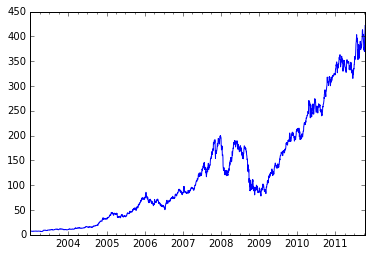

In [299]:
# 任意一列调用plot即可生成简单的图表
close_px['AAPL'].plot()

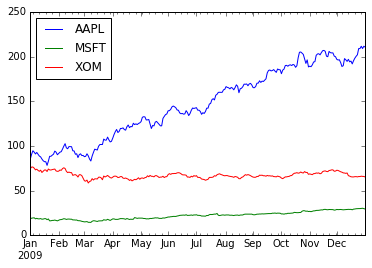

In [300]:
# 绘制2009年数据
close_px.ix['2009'].plot()

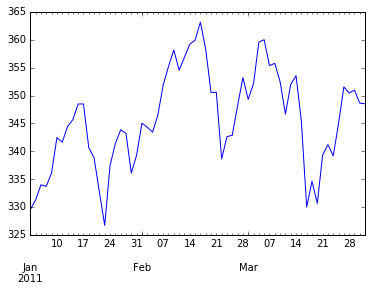

In [301]:
# 苹果2011年1月到3月的每日股价：
close_px['AAPL'].ix['01-2011':'03-2011'].plot()

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  from ipykernel import kernelapp as app


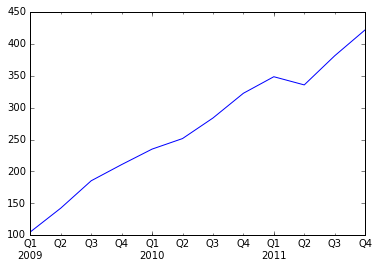

In [302]:
# 季度型频率的数据会用季度标记进行格式化：
appl_q = close_px['AAPL'].resample('Q-DEC', fill_method='ffill')
appl_q.ix['2009':].plot()

### 移动窗口函数
在移动窗口（带有指数衰减权数）上计算各种统计函数也是一种常见于时间序列的数组变换。成为移动窗口函数（moving window function），其中包括窗口不定长的函数（如指数加权移动平均）。跟其他统计函数一样，移动窗口函数也会自动排除缺失值。

*rolling_mean*是其中最简单的一个，接受一个TimeSeries或DF以及一个window（表示期数）：

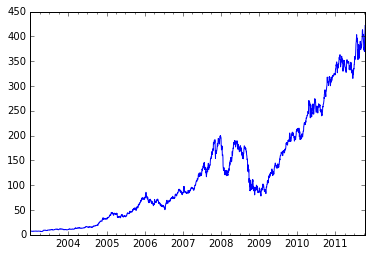

In [303]:
close_px.AAPL.plot()

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250,center=False).mean()
  if __name__ == '__main__':


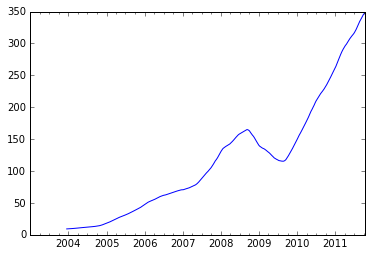

In [304]:
pd.rolling_mean(close_px.AAPL, 250).plot()

rolling_mean滚动平均值，窗口大小为250，是指窗口中存在250个非NA值，然而，在时间序列开始处尚不足窗口期的那些数据就是个特例：

In [305]:
appl_std250 = pd.rolling_std(close_px.AAPL, 250, min_periods=10)
appl_std250[:]

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=10,window=250,center=False).std()
  if __name__ == '__main__':


2003-01-02          NaN
2003-01-03          NaN
2003-01-06          NaN
2003-01-07          NaN
2003-01-08          NaN
2003-01-09          NaN
2003-01-10          NaN
2003-01-13          NaN
2003-01-14          NaN
2003-01-15     0.077496
2003-01-16     0.074760
2003-01-17     0.112368
2003-01-20     0.132011
2003-01-21     0.149286
2003-01-22     0.169008
2003-01-23     0.168760
2003-01-24     0.184135
2003-01-27     0.182546
2003-01-28     0.178117
2003-01-29     0.181870
2003-01-30     0.178049
2003-01-31     0.174123
2003-02-03     0.171381
2003-02-04     0.168142
2003-02-05     0.164639
2003-02-06     0.161346
2003-02-07     0.161412
2003-02-10     0.158676
2003-02-11     0.156074
2003-02-12     0.153436
                ...    
2011-09-05    25.320023
2011-09-06    25.218932
2011-09-07    25.174057
2011-09-08    25.134226
2011-09-09    25.071408
2011-09-12    25.010059
2011-09-13    24.939448
2011-09-14    24.901731
2011-09-15    24.854159
2011-09-16    24.854202
2011-09-19    24

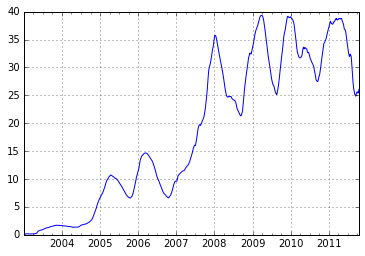

In [306]:
appl_std250.plot(grid=True) # 250日每日回报标准差

C:\Python27\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.expanding_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.expanding(min_periods=60).mean()


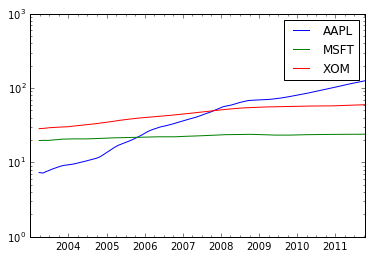

In [307]:
# 通过rolling_mean定义扩展平均
# expanding_mean = lambda x: rolling_mean(x, len(x), min_periods=1)

# 对DF调用rolling_mean或类似的函数，会应用到所有列上
pd.expanding_mean(close_px, 60).plot(logy=True) # 各个公司60日均线，对数Y轴

### 指数加权函数
相比于等权统计，它能适应更快的变化。例如，苹果60日移动平均和span=60（时间间隔）的指数加权踢动平均对比：

C:\Python27\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=50,window=60,center=False).mean()
C:\Python27\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True).mean()


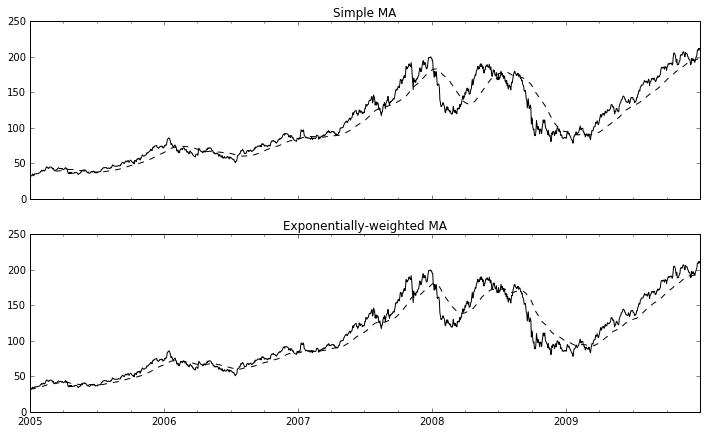

In [315]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 7))

aapl_px = close_px.AAPL['2005':'2009']

# Series.rolling(min_periods=50,window=60,center=False).mean()
ma60 = pd.rolling_mean(aapl_px, 60, min_periods=50) # 等权统计，滚动平均
# Series.ewm(ignore_na=False,span=60,min_periods=0,adjust=True).mean()
ewma60 = pd.ewma(aapl_px, span=60) # 指数加权，时间间隔60

aapl_px.plot(style='k-', ax=axes[0])
ma60.plot(style='k--', ax=axes[0])
aapl_px.plot(style='k-', ax=axes[1])
ewma60.plot(style='k--', ax=axes[1])
axes[0].set_title('Simple MA')
axes[1].set_title('Exponentially-weighted MA')

### 二元移动窗口函数
有些统计运算（如相关系数和协方差）需要在两个时间序列上执行。例如，金融分析师常常对某只股票对某个参考指数的相关系数感兴趣。可以通过计算百分数变化并使用rolling_corr的方法得到该结果：

C:\Python27\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=100,window=125).corr(other=<Series>)


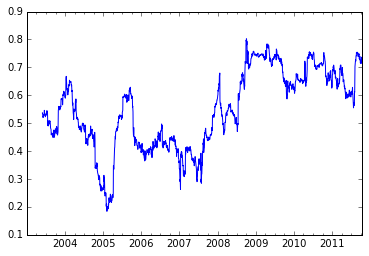

In [320]:
spx_px = close_px_all['SPX']
spx_rets = spx_px / spx_px.shift(1) - 1
returns = close_px.pct_change() # 百分比变化
corr = pd.rolling_corr(returns.AAPL, spx_rets, 125, min_periods=100)
corr.plot() # AAPL六个月的回报与标准普尔500指数的相关系数

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=125).corr(other=<Series>)
  from ipykernel import kernelapp as app


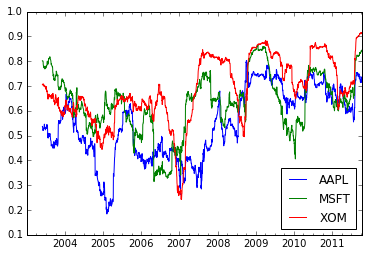

In [321]:
# 计算多列的相关系数
corr = pd.rolling_corr(returns, spx_rets, 125, min_periods=100)
corr.plot()